In [ ]:
# pip install folium

In [44]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [45]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import re
from folium.plugins import BeautifyIcon

# Clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score



In [46]:
# cut-off된 데이터프레임 호출
df = pd.read_csv("/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/최종데이터_등급.csv", encoding='cp949')
df = df[df['avg'] <= 5]
# df = df[df['공실여부'] == 1]
df['multi_pop'] = df['1인가구']*df['거주인구수']
df

,Unnamed: 0,역사명,역위도,역경도,행정동,공실여부,공실_총_면적,1인가구,4인가구,1-4_사업체수,5-9_사업체수,9인이하_사업체수,거주인구수,일평균 승하차인구수,1인 가구,1인 가구 등급,9인이하_사업체수.1,9인이하_사업체수 등급,거주인구수.1,거주인구수 등급,일평균 승하차인구수.1,일평균 승하차인구수 등급,sum,avg,multi_pop
2,68,가산디지털단지역,37.481393,126.882605,가산동,0,0.00,12360,651,9907,3458,13365,23377,88148.82143,0.96,1,0.98,1,0.50,5,0.97,1,8,2.00,288939720
6,43,강남구청역,37.517160,127.041219,삼성동,1,73.30,4601,1317,929,46,975,22745,39223.67857,0.54,5,0.19,7,0.46,5,0.81,3,20,5.00,104649745
7,86,강남역,37.497202,127.028054,역삼1동,1,39.90,17411,1063,10193,2943,13136,35606,116604.32140,0.98,1,0.97,1,0.87,3,0.99,1,6,1.50,619936066
9,184,강동역,37.535879,127.132079,성내2동,0,0.00,6810,1060,1542,182,1724,23930,26892.17857,0.80,3,0.53,5,0.52,5,0.66,4,17,4.25,162963300
10,9,강변역,37.534877,127.094694,구의3동,0,0.00,4159,2264,2098,371,2469,28891,49017.03571,0.46,5,0.68,4,0.69,4,0.87,3,16,4.00,120157669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,101,합정역,37.549699,126.914124,서교동,1,30.74,10060,995,6859,1679,8538,25051,68814.07143,0.93,2,0.96,1,0.59,5,0.94,2,10,2.50,252013060
287,22,홍대입구역,37.557548,126.925258,서교동,0,0.00,10060,995,6859,1679,8538,25051,105989.67860,0.93,2,0.96,1,0.59,5,0.98,1,9,2.25,252013060
290,163,화곡역,37.541757,126.840295,화곡1동,0,0.00,13875,2402,2560,343,2903,52026,42063.42857,0.97,1,0.74,4,0.99,1,0.83,3,9,2.25,721860750
291,220,화랑대역,37.620131,127.084426,공릉2동,0,0.00,5896,3210,1648,200,1848,39147,15257.46429,0.69,4,0.58,5,0.95,2,0.38,6,17,4.25,230810712


In [47]:
raw = df[['역사명', '역위도', '역경도','multi_pop','1인가구','4인가구','거주인구수','공실_총_면적','9인이하_사업체수','일평균 승하차인구수']]
raw.head()

,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수
2,가산디지털단지역,37.481393,126.882605,288939720,12360,651,23377,0.0,13365,88148.82143
6,강남구청역,37.517160,127.041219,104649745,4601,1317,22745,73.3,975,39223.67857
7,강남역,37.497202,127.028054,619936066,17411,1063,35606,39.9,13136,116604.32140
9,강동역,37.535879,127.132079,162963300,6810,1060,23930,0.0,1724,26892.17857
10,강변역,37.534877,127.094694,120157669,4159,2264,28891,0.0,2469,49017.03571


In [48]:
# scaling (Robust Scaler)
data = raw.copy()
data = data[['multi_pop','9인이하_사업체수','일평균 승하차인구수']]
data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns, index = data.index)
data.head()

,multi_pop,9인이하_사업체수,일평균 승하차인구수
2,0.389874,0.925729,0.702160
6,0.130150,0.012821,0.299409
7,0.856355,0.908856,0.936406
9,0.212332,0.068008,0.197896
10,0.152005,0.122900,0.380028


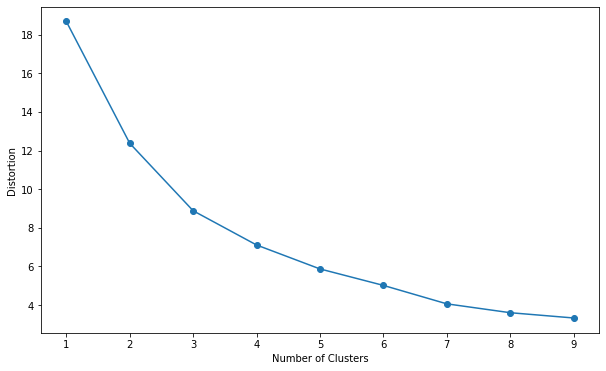

In [49]:
# data 참조
data_elbow = data.copy()

distortions = []
for i in range(1,10):
    km = KMeans(
    n_clusters= i, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
    )
    km.fit(data_elbow)
    distortions.append(km.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,10), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [50]:
# k-means clustering

data1 = data.copy()
model1 = KMeans(n_clusters=3, random_state=2021009, algorithm='auto')
model1.fit(data1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2021009, tol=0.0001, verbose=0)

In [51]:
# 각 군집(cluster) 표시
pred1 = model1.predict(data1)
pred1

array([1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 0,
       2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2], dtype=int32)

In [52]:
# 원형 데이터에 군집 예측치 추가
data1['k_means_cluster'] = pred1
data1

,multi_pop,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
2,0.389874,0.925729,0.702160,1
6,0.130150,0.012821,0.299409,0
7,0.856355,0.908856,0.936406,1
9,0.212332,0.068008,0.197896,2
10,0.152005,0.122900,0.380028,0
...,...,...,...,...
284,0.337832,0.570071,0.542997,1
287,0.337832,0.570071,0.849026,1
290,1.000000,0.154878,0.322786,2
291,0.307951,0.077144,0.102119,2


In [53]:
# 군집별 통계(평균)
cluster_k1 = data1.groupby('k_means_cluster')
cluster_k1.mean()

,multi_pop,9인이하_사업체수,일평균 승하차인구수
k_means_cluster,,,
0,0.163868,0.125675,0.444096
1,0.456706,0.870130,0.551588
2,0.288204,0.152910,0.135435


In [54]:
raw1 = raw.copy()
raw1['k_means_cluster'] = pred1
raw1

,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
2,가산디지털단지역,37.481393,126.882605,288939720,12360,651,23377,0.00,13365,88148.82143,1
6,강남구청역,37.517160,127.041219,104649745,4601,1317,22745,73.30,975,39223.67857,0
7,강남역,37.497202,127.028054,619936066,17411,1063,35606,39.90,13136,116604.32140,1
9,강동역,37.535879,127.132079,162963300,6810,1060,23930,0.00,1724,26892.17857,2
10,강변역,37.534877,127.094694,120157669,4159,2264,28891,0.00,2469,49017.03571,0
...,...,...,...,...,...,...,...,...,...,...,...
284,합정역,37.549699,126.914124,252013060,10060,995,25051,30.74,8538,68814.07143,1
287,홍대입구역,37.557548,126.925258,252013060,10060,995,25051,0.00,8538,105989.67860,1
290,화곡역,37.541757,126.840295,721860750,13875,2402,52026,0.00,2903,42063.42857,2
291,화랑대역,37.620131,127.084426,230810712,5896,3210,39147,0.00,1848,15257.46429,2


In [55]:
raw1.to_csv('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/지도 시각화/최종데이터_등급.csv')

In [56]:
# pd.set_option("display.max_rows", None)

analysis1 = raw1.copy()
analysis1 = analysis1.sort_values(by='k_means_cluster')
analysis1

,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
179,신대방역,37.487413,126.913594,94517932,4051,1830,23332,0.0,981,40918.35714,0
46,김포공항역,37.562298,126.801711,135291720,5820,1172,23246,0.0,3090,45037.35714,0
47,까치산역,37.531684,126.846743,119816610,4870,1325,24603,0.0,1216,44617.32143,0
138,상봉역,37.595667,127.085620,81889026,3342,1835,24503,0.0,1068,35750.21429,0
50,남부터미널역,37.484825,127.016190,82729906,3997,1387,20698,0.0,3244,44289.82143,0
...,...,...,...,...,...,...,...,...,...,...,...
107,문래역,37.517797,126.894544,128205744,3903,2603,32848,0.0,4751,30473.46429,2
101,면목역,37.588524,127.087425,302126643,8901,1695,33943,0.0,2471,24092.35714,2
100,먹골역,37.610734,127.077589,180596452,5183,2488,34844,0.0,1456,15783.92857,2
178,신대방삼거리역,37.499688,126.928052,277274880,7232,2870,38340,0.0,1522,24607.03571,2


In [57]:
is_0 = raw1['k_means_cluster'] == 0
is_1 = raw1['k_means_cluster'] == 1
is_2 = raw1['k_means_cluster'] == 2

In [ ]:
print(len(raw1[is_0]))
raw1[is_0]

45


,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
6,강남구청역,37.517160,127.041219,104649745,4601,1317,22745,73.30,975,39223.67857,0
10,강변역,37.534877,127.094694,120157669,4159,2264,28891,0.00,2469,49017.03571,0
17,건대입구역,37.540609,127.069963,88983426,5097,824,17458,101.72,1734,75108.89286,0
22,고속터미널역,37.504366,127.004740,34302220,1805,1517,19004,34.57,2884,118627.64290,0
23,공덕역,37.543428,126.951797,326557514,8761,2183,37274,65.71,2569,53849.03571,0
30,교대역,37.493201,127.014124,82729906,3997,1387,20698,15.00,3244,65872.39286,0
31,구로디지털단지역,37.485162,126.901485,186503644,7894,1138,23626,0.00,6147,85471.96429,0
36,구의역,37.536919,127.085730,102798592,4108,1738,25024,23.10,1343,35378.17857,0
40,군자역,37.557134,127.079433,67704525,4347,759,15575,75.92,1501,38280.28571,0
46,김포공항역,37.562298,126.801711,135291720,5820,1172,23246,0.00,3090,45037.35714,0


In [ ]:
print(len(raw1[is_1]))
raw1[is_1]

10


,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
2,가산디지털단지역,37.481393,126.882605,288939720,12360,651,23377,0.00,13365,88148.82143,1
7,강남역,37.497202,127.028054,619936066,17411,1063,35606,39.90,13136,116604.32140,1
155,선릉역,37.504429,127.048819,619936066,17411,1063,35606,136.04,13136,91382.53571,1
175,신논현역,37.504724,127.025380,619936066,17411,1063,35606,0.00,13136,45780.75000,1
196,안국역,37.576664,126.985479,30300024,4206,194,7204,28.80,14373,29997.32143,1
212,역삼역,37.500545,127.036394,619936066,17411,1063,35606,47.95,13136,69047.89286,1
254,종각역,37.570203,126.982948,30300024,4206,194,7204,139.19,14373,44804.78571,1
255,종로3가역,37.571394,126.991345,30300024,4206,194,7204,351.58,14373,38007.14286,1
284,합정역,37.549699,126.914124,252013060,10060,995,25051,30.74,8538,68814.07143,1
287,홍대입구역,37.557548,126.925258,252013060,10060,995,25051,0.00,8538,105989.67860,1


In [ ]:
print(len(raw1[is_2]))
raw1[is_2]

103


,역사명,역위도,역경도,multi_pop,1인가구,4인가구,거주인구수,공실_총_면적,9인이하_사업체수,일평균 승하차인구수,k_means_cluster
9,강동역,37.535879,127.132079,162963300,6810,1060,23930,0.0,1724,26892.178570,2
12,개봉역,37.494698,126.858504,181308753,5319,2207,34087,0.0,1618,34155.964290,2
14,개화산역,37.572312,126.806289,135291720,5820,1172,23246,0.0,3090,8357.142857,2
19,경찰병원역,37.495765,127.124300,126710280,4770,1762,26564,0.0,3109,10565.142860,2
21,고려대역,37.590339,127.035864,255139782,6533,2792,39054,0.0,1928,11632.500000,2
...,...,...,...,...,...,...,...,...,...,...,...
280,한성대입구역,37.588385,127.005999,132985868,5783,1418,22996,0.0,1728,21139.785710,2
283,한티역,37.496208,127.052883,73197352,2188,3266,33454,0.0,1523,23580.392860,2
290,화곡역,37.541757,126.840295,721860750,13875,2402,52026,0.0,2903,42063.428570,2
291,화랑대역,37.620131,127.084426,230810712,5896,3210,39147,0.0,1848,15257.464290,2


In [58]:
geo_json = '/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/seoul_municipalities_geo_simple.json'
with open(geo_json,encoding = 'utf-8') as file:
  geo = json.loads(file.read())
  file.close()
geo

{'features': [{'geometry': {'coordinates': [[[127.11519584981606,
       37.557533180704915],
      [127.11879551821994, 37.557222485451305],
      [127.12146867175024, 37.55986003393365],
      [127.12435254630417, 37.56144246249796],
      [127.13593925898998, 37.56564793048277],
      [127.14930548011061, 37.56892250303897],
      [127.15511020940411, 37.57093642128295],
      [127.16683184366129, 37.57672487388627],
      [127.17038810813094, 37.576465605301046],
      [127.17607118428914, 37.57678573961056],
      [127.17905504160184, 37.57791388161732],
      [127.17747787800164, 37.57448983055031],
      [127.1781775408844, 37.571481967974336],
      [127.17995281860672, 37.569309661290504],
      [127.18122821955262, 37.56636089217979],
      [127.18169407550688, 37.56286338914073],
      [127.18408792330152, 37.55814280369575],
      [127.18350810324185, 37.550053002101485],
      [127.1852644795464, 37.54888592026534],
      [127.18480906237207, 37.545296888806796],
      [12

In [59]:
# 저장용
cluster0 = raw1.copy()
cluster0 = cluster0[is_0]
cluster0 = cluster0[['역사명','역위도','역경도']]
cluster0.reset_index(drop = True,inplace = True)

# 접수용
cluster1 = raw1.copy()
cluster1 = cluster1[is_1]
cluster1 = cluster1[['역사명','역위도','역경도']]
cluster1.reset_index(drop = True,inplace = True)

lat = raw1['역위도'].mean()
long = raw1['역경도'].mean()
map = folium.Map([lat,long],zoom_start = 11.5, tiles = 'cartodbpositron')
# folium.GeoJson(geo,style_function=lambda x: {'fillColor':'Blues','color':'Blues'},highlight_function=lambda feature: {'fillcolor':'darkblue','color':'darkblue'},).add_to(map)
folium.GeoJson(geo,style_function=lambda x: {'fillColor':'azure','color':'lightblue'}).add_to(map)

coords1 = []
coords2 = []
coords3 = []
coords4 = []

minor1 = []
minor2 = []
minor3 = []
minor4 = []

for i in range(len(cluster1)):
  if cluster1['역사명'][i] in ['강남역','선릉역','역삼역','신논현역']:
    x = cluster1['역위도'][i]
    y = cluster1['역경도'][i]
    coords1.append([x,y])
  elif cluster1['역사명'][i] in ['종각역']:
    x = cluster1['역위도'][i]
    y = cluster1['역경도'][i]
    coords2.append([x,y])
  elif cluster1['역사명'][i] in ['홍대입구역','합정역']:
    x = cluster1['역위도'][i]
    y = cluster1['역경도'][i]
    coords3.append([x,y])
  elif cluster1['역사명'][i] in ['가산디지털단지역']:
    x = cluster1['역위도'][i]
    y = cluster1['역경도'][i]
    coords4.append([x,y])
  elif cluster1['역사명'][i] in ['종로3가역','안국역']:
    x = cluster1['역위도'][i]
    y = cluster1['역경도'][i]
    minor2.append([x,y])

for i in range(len(cluster0)):
  if cluster0['역사명'][i] in ['강남구청역','고속터미널역','교대역','사당역','신사역','양재역','잠실새내역','잠실역']:
    x = cluster0['역위도'][i]
    y = cluster0['역경도'][i]
    minor1.append([x,y])
  elif cluster0['역사명'][i] in ['공덕역','당산역','신촌역','연신내역']: # 신도림?
    x = cluster0['역위도'][i]
    y = cluster0['역경도'][i]
    minor3.append([x,y])
  elif cluster0['역사명'][i] in ['신도림역']:
    x = cluster0['역위도'][i]
    y = cluster0['역경도'][i]
    minor4.append([x,y])



# for j in range(len(coords1)):
#   folium.Marker(location = coords1[j], icon = folium.Icon(color='blue',icon = 'train',prefix='fa')).add_to(map)
# for j in range(len(coords2)):
#   folium.Marker(location = coords2[j], icon = folium.Icon(color='orange',icon = 'train',prefix='fa')).add_to(map)
# for j in range(len(coords3)):
#   folium.Marker(location = coords3[j], icon = folium.Icon(color='green',icon = 'train',prefix='fa')).add_to(map)
# for j in range(len(coords4)):
#   folium.Marker(location = coords4[j], icon = folium.Icon(color='red',icon = 'train',prefix='fa')).add_to(map)

# for j in range(len(minor1)):
#   folium.Circle(location = minor1[j], radius = 200, color = '#0000ff', fill = 'crimson').add_to(map)
# for j in range(len(minor2)):
#   folium.Circle(location = minor2[j], radius = 200, color = '#ffa500', fill = 'crimson').add_to(map)
# for j in range(len(minor3)):
#   folium.Circle(location = minor3[j], radius = 200, color = '#008000', fill = 'crimson').add_to(map)
# for j in range(len(minor4)):
#   folium.Circle(location = minor4[j], radius = 200, color = '#FF0000', fill = 'crimson').add_to(map)

map

In [62]:
# 복합형
cluster2 = raw1.copy()
cluster2 = cluster2[is_2]
cluster2 = cluster2[['역사명','역위도','역경도']]
cluster2.reset_index(drop = True,inplace = True)

# lat = raw1['역위도'].mean()
# long = raw1['역경도'].mean()
# map = folium.Map([lat,long],zoom_start = 12, tiles = 'cartodbpositron')
# folium.GeoJson(geo).add_to(map)

complex1 = []

for i in range(len(cluster2)):
  if cluster2['역사명'][i] in ['발산역','망원역','서초역','태릉입구역','남구로역']:
    x = cluster2['역위도'][i]
    y = cluster2['역경도'][i]
    complex1.append([x,y])

for j in range(len(complex1)):
  folium.Circle(location = complex1[j], radius = 200, color = '#000000', fill = 'crimson').add_to(map)
# for j in range(len(complex1)):
#   folium.Marker(location = complex1[j], tooltip = 'star', icon = BeautifyIcon(icon='star',inner_icon_style = 'color:red;font-size:30px;',border_color='transparent',background_color='transparent')).add_to(map)

map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/최종1.html')

In [63]:
map

In [ ]:
# # 전체 합치기

# cluster0 = raw1.copy()
# cluster0 = cluster0[is_0]
# cluster0 = cluster0[['역사명','역위도','역경도']]
# cluster0.reset_index(drop = True,inplace = True)

# cluster1 = raw1.copy()
# cluster1 = cluster1[is_1]
# cluster1 = cluster1[['역사명','역위도','역경도']]
# cluster1.reset_index(drop = True,inplace = True)

# cluster2 = raw1.copy()
# cluster2 = cluster2[is_2]
# cluster2 = cluster2[['역사명','역위도','역경도']]
# cluster2.reset_index(drop = True,inplace = True)

# lat = raw1['역위도'].mean()
# long = raw1['역경도'].mean()
# map = folium.Map([lat,long],zoom_start = 12)

# # # 클러스터 0
# # coords0 = []

# # for i in range(len(cluster0)):
# #   x = cluster0['역위도'][i]
# #   y = cluster0['역경도'][i]
# #   coords0.append([x,y])

# # for j in range(len(coords0)):
# #   folium.Marker(location = coords0[j], icon = folium.Icon(color='red',icon = 'train',prefix='fa'), popup = cluster0['역사명'][j],).add_to(map)

# # 클러스터 1
# coords1 = []

# for i in range(len(cluster1)):
#   x = cluster1['역위도'][i]
#   y = cluster1['역경도'][i]
#   coords1.append([x,y])

# for j in range(len(coords1)):
#   folium.Marker(location = coords1[j], icon = folium.Icon(color='blue',icon = 'train',prefix='fa'), popup = cluster1['역사명'][j],).add_to(map)

# # 클러스터 2
# coords2 = []

# for i in range(len(cluster2)):
#   x = cluster2['역위도'][i]
#   y = cluster2['역경도'][i]
#   coords2.append([x,y])

# for j in range(len(coords2)):
#   folium.Marker(location = coords2[j], icon = folium.Icon(color='gray',icon = 'train',prefix='fa'), popup = cluster2['역사명'][j],).add_to(map)

# map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster_합.html')
# map

In [ ]:
# cluster = 0
cluster0 = raw1.copy()
cluster0 = cluster0[is_0]
cluster0 = cluster0[['역사명','역위도','역경도']]
cluster0.reset_index(drop = True,inplace = True)
cluster0

,역사명,역위도,역경도
0,강남구청역,37.517160,127.041219
1,강변역,37.534877,127.094694
2,건대입구역,37.540609,127.069963
3,고속터미널역,37.504366,127.004740
4,공덕역,37.543428,126.951797
5,교대역,37.493201,127.014124
6,구로디지털단지역,37.485162,126.901485
7,구의역,37.536919,127.085730
8,군자역,37.557134,127.079433
9,김포공항역,37.562298,126.801711


In [ ]:
lat = cluster0['역위도'].mean()
long = cluster0['역경도'].mean()

map = folium.Map([lat,long],zoom_start = 11.5, tiles = 'cartodbpositron')
folium.GeoJson(geo,style_function=lambda x: {'fillColor':'azure','color':'lightblue'}).add_to(map)

coords0 = []

for i in range(len(cluster0)):
  x = cluster0['역위도'][i]
  y = cluster0['역경도'][i]
  coords0.append([x,y])


for j in range(len(coords0)):
  folium.Circle(location = coords0[j], radius = 200, color = 'blue', fill = 'crimson').add_to(map)

map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster0.html')
map

In [ ]:
# cluster = 1
cluster1 = raw1.copy()
cluster1 = cluster1[is_1]
cluster1 = cluster1[['역사명','역위도','역경도']]
cluster1.reset_index(drop = True,inplace = True)
cluster1

,역사명,역위도,역경도
0,가산디지털단지역,37.481393,126.882605
1,강남역,37.497202,127.028054
2,선릉역,37.504429,127.048819
3,신논현역,37.504724,127.025380
4,안국역,37.576664,126.985479
5,역삼역,37.500545,127.036394
6,종각역,37.570203,126.982948
7,종로3가역,37.571394,126.991345
8,합정역,37.549699,126.914124
9,홍대입구역,37.557548,126.925258


In [ ]:
lat = cluster1['역위도'].mean()
long = cluster1['역경도'].mean()

map2 = folium.Map([lat,long],zoom_start = 11.5, tiles = 'cartodbpositron')
folium.GeoJson(geo,style_function=lambda x: {'fillColor':'azure','color':'lightblue'}).add_to(map2)

coords1 = []

for i in range(len(cluster1)):
  x = cluster1['역위도'][i]
  y = cluster1['역경도'][i]
  coords1.append([x,y])


for j in range(len(coords1)):
  folium.Circle(location = coords1[j], radius = 200, color = 'red', fill = 'crimson').add_to(map2)

map2.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster1.html')
map2

In [ ]:
# cluster = 2
cluster2 = raw1.copy()
cluster2 = cluster2[is_2]
cluster2 = cluster2[['역사명','역위도','역경도']]
cluster2.reset_index(drop = True,inplace = True)
cluster2

,역사명,역위도,역경도
0,강동역,37.535879,127.132079
1,개봉역,37.494698,126.858504
2,개화산역,37.572312,126.806289
3,경찰병원역,37.495765,127.124300
4,고려대역,37.590339,127.035864
...,...,...,...
98,한성대입구역,37.588385,127.005999
99,한티역,37.496208,127.052883
100,화곡역,37.541757,126.840295
101,화랑대역,37.620131,127.084426


In [ ]:
lat = cluster2['역위도'].mean()
long = cluster2['역경도'].mean()

map3 = folium.Map([lat,long],zoom_start = 11.5, tiles = 'cartodbpositron')
folium.GeoJson(geo,style_function=lambda x: {'fillColor':'azure','color':'lightblue'}).add_to(map3)

coords2 = []

for i in range(len(cluster2)):
  x = cluster2['역위도'][i]
  y = cluster2['역경도'][i]
  coords2.append([x,y])

for j in range(len(coords2)):
  folium.Circle(location = coords2[j], radius = 200, color = '#000000', fill = 'crimson').add_to(map3)

map3.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster2.html')
map3

In [ ]:
# lat = cluster1['역위도'].mean()
# long = cluster1['역경도'].mean()

# map = folium.Map([lat,long],zoom_start = 12, tiles = 'cartodbpositron')

# coords1 = []
# coords2 = []
# coords3 = []
# coords4 = []

# for i in range(len(cluster1)):
#   if cluster1['역사명'][i] in ['강남역','선릉역','역삼역','신논현역']:
#     x = cluster1['역위도'][i]
#     y = cluster1['역경도'][i]
#     coords1.append([x,y])
#   elif cluster1['역사명'][i] in ['안국역','종각역','종로3가역']:
#     x = cluster1['역위도'][i]
#     y = cluster1['역경도'][i]
#     coords2.append([x,y])
#   elif cluster1['역사명'][i] in ['홍대입구역','합정역']:
#     x = cluster1['역위도'][i]
#     y = cluster1['역경도'][i]
#     coords3.append([x,y])
#   else:
#     x = cluster1['역위도'][i]
#     y = cluster1['역경도'][i]
#     coords4.append([x,y])


# for j in range(len(coords1)):
#   folium.Circle(location = coords1[j], radius = 200, color = '#0000FF', fill = 'crimson').add_to(map)
# for j in range(len(coords2)):
#   folium.Circle(location = coords2[j], radius = 200, color = '#FF0000', fill = 'crimson').add_to(map)
# for j in range(len(coords3)):
#   folium.Circle(location = coords3[j], radius = 200, color = '#000000', fill = 'crimson').add_to(map)
# for j in range(len(coords4)):
#   folium.Circle(location = coords4[j], radius = 200, color = '#008000', fill = 'crimson').add_to(map)

# # map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster1.html')
# map

In [ ]:
# df = df[['역사명','역위도','역경도']]
# df

In [ ]:
# lat = df['역위도'].mean()
# long = df['역경도'].mean()

# map = folium.Map([lat,long],zoom_start = 9)

# coords = []

# for i in range(len(df)):
#   x = df['역위도'][i]
#   y = df['역경도'][i]
#   coords.append([x,y])

# for j in range(len(coords)):
#   folium.Circle(location = coords[j], radius = 150, color = '#000000', fill = 'crimson').add_to(map)

# map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/test2.html')


In [ ]:
# # 전체 합치기

# cluster0 = raw1.copy()
# cluster0 = cluster0[is_0]
# cluster0 = cluster0[['역사명','역위도','역경도']]
# cluster0.reset_index(drop = True,inplace = True)

# cluster1 = raw1.copy()
# cluster1 = cluster1[is_1]
# cluster1 = cluster1[['역사명','역위도','역경도']]
# cluster1.reset_index(drop = True,inplace = True)

# cluster2 = raw1.copy()
# cluster2 = cluster2[is_2]
# cluster2 = cluster2[['역사명','역위도','역경도']]
# cluster2.reset_index(drop = True,inplace = True)

# lat = raw1['역위도'].mean()
# long = raw1['역경도'].mean()
# map = folium.Map([lat,long],zoom_start = 12, tiles = 'cartodbpositron')
# folium.GeoJson(geo).add_to(map)

# # # 클러스터 0
# # coords0 = []

# # for i in range(len(cluster0)):
# #   x = cluster0['역위도'][i]
# #   y = cluster0['역경도'][i]
# #   coords0.append([x,y])

# # for j in range(len(coords0)):
# #   folium.Marker(location = coords0[j], icon = folium.Icon(color='red',icon = 'train',prefix='fa'), popup = cluster0['역사명'][j],).add_to(map)

# # 클러스터 1
# coords1 = []

# for i in range(len(cluster1)):
#   x = cluster1['역위도'][i]
#   y = cluster1['역경도'][i]
#   coords1.append([x,y])

# for j in range(len(coords1)):
#   folium.Marker(location = coords1[j], icon = folium.Icon(color='blue',icon = 'train',prefix='fa'), popup = cluster1['역사명'][j]).add_to(map)

# # # 클러스터 2
# # coords2 = []

# # for i in range(len(cluster2)):
# #   x = cluster2['역위도'][i]
# #   y = cluster2['역경도'][i]
# #   coords2.append([x,y])

# # for j in range(len(coords2)):
# #   folium.Marker(location = coords2[j], icon = folium.Icon(color='gray',icon = 'train',prefix='fa'), popup = cluster2['역사명'][j],).add_to(map)

# map.save('/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/cluster_합.html')

In [ ]:
# map

In [ ]:
# geo_json = '/content/drive/Shareddrives/서울시 빅데이터 캠퍼스 공모전/클러스터링/seoul_municipalities_geo_simple.json'
# with open(geo_json,encoding = 'utf-8') as file:
#   geo = json.loads(file.read())
#   file.close()
# geo